In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
def debug_temperature_processing(session_path: str):
    """
    Debug function to analyze temperature data processing step by step
    """
    print("=== TEMPERATURE PROCESSING DEBUG ===\n")
    
    # 1. Read raw TEMP.csv file
    temp_file = f"{session_path}/TEMP.csv"
    print(f"1. Reading raw temperature file: {temp_file}")

    try:
        with open(temp_file, 'r') as f:
            lines = f.readlines()
        
        print(f"   Total lines in file: {len(lines)}")
        print(f"   First 5 lines:")
        for i, line in enumerate(lines[:5]):
            print(f"   Line {i}: {line.strip()}")
        
        # 2. Parse header information
        print(f"\n2. Parsing header information:")
        start_time = float(lines[0].strip())
        sampling_rate = float(lines[1].strip())
        
        print(f"   Start timestamp (Unix): {start_time}")
        print(f"   Start time (readable): {datetime.fromtimestamp(start_time)}")
        print(f"   Sampling rate: {sampling_rate} Hz")
        
        # 3. Parse temperature data
        print(f"\n3. Parsing temperature values:")
        temp_values = []
        for i, line in enumerate(lines[2:], start=2):
            try:
                value = float(line.strip())
                temp_values.append(value)
            except ValueError:
                print(f"   Warning: Could not parse line {i}: {line.strip()}")
                continue
        
        print(f"   Successfully parsed {len(temp_values)} temperature values")
        print(f"   First 10 values: {temp_values[:10]}")
        print(f"   Last 10 values: {temp_values[-10:]}")
        
        # 4. Basic statistics
        print(f"\n4. Raw temperature statistics:")
        temp_array = np.array(temp_values)
        print(f"   Min: {np.min(temp_array):.4f}")
        print(f"   Max: {np.max(temp_array):.4f}")
        print(f"   Mean: {np.mean(temp_array):.4f}")
        print(f"   Std: {np.std(temp_array):.4f}")
        print(f"   Median: {np.median(temp_array):.4f}")
        
        # 5. Check for anomalies
        print(f"\n5. Anomaly detection:")
        zero_count = np.sum(temp_array == 0)
        negative_count = np.sum(temp_array < 0)
        very_low_count = np.sum(temp_array < 20)  # Below 20°C is suspicious
        very_high_count = np.sum(temp_array > 50)  # Above 50°C is suspicious
        
        print(f"   Zero values: {zero_count} ({zero_count/len(temp_array)*100:.2f}%)")
        print(f"   Negative values: {negative_count} ({negative_count/len(temp_array)*100:.2f}%)")
        print(f"   Values < 20°C: {very_low_count} ({very_low_count/len(temp_array)*100:.2f}%)")
        print(f"   Values > 50°C: {very_high_count} ({very_high_count/len(temp_array)*100:.2f}%)")
        
        # 6. Generate timestamps as done in original code
        print(f"\n6. Timestamp generation:")
        n_samples = len(temp_values)
        timestamps = start_time + np.arange(n_samples) / sampling_rate
        
        print(f"   Number of samples: {n_samples}")
        print(f"   Expected duration: {n_samples / sampling_rate / 60:.2f} minutes")
        print(f"   First timestamp: {timestamps[0]} ({datetime.fromtimestamp(timestamps[0])})")
        print(f"   Last timestamp: {timestamps[-1]} ({datetime.fromtimestamp(timestamps[-1])})")
        
        # 7. Create DataFrame as in original code
        print(f"\n7. Creating DataFrame:")
        df = pd.DataFrame({
            'timestamp': pd.to_datetime(timestamps, unit='s'),
            'TEMP': temp_values,
            'sensor': 'TEMP'
        })
        
        print(f"   DataFrame shape: {df.shape}")
        print(f"   DataFrame info:")
        print(df.info())
        print(f"\n   First 5 rows:")
        print(df.head())
        print(f"\n   Temperature column statistics:")
        print(df['TEMP'].describe())
        
        # 8. Simulate window processing
        print(f"\n8. Simulating window processing:")
        window_size = 10  # seconds
        df_indexed = df.set_index('timestamp')
        
        # Generate windows
        start_time_dt = df_indexed.index.min().floor(f'{window_size}s')
        end_time_dt = df_indexed.index.max().ceil(f'{window_size}s')
        windows = pd.date_range(start=start_time_dt, end=end_time_dt, freq=f'{window_size}s')
        
        print(f"   Number of windows: {len(windows)-1}")
        print(f"   Window start: {start_time_dt}")
        print(f"   Window end: {end_time_dt}")
        
        # Process first few windows
        print(f"\n   Processing first 3 windows:")
        for i in range(min(3, len(windows)-1)):
            window_start = windows[i]
            window_end = windows[i] + pd.Timedelta(seconds=window_size)
            
            window_data = df_indexed[(df_indexed.index >= window_start) & (df_indexed.index < window_end)]
            temp_data = window_data['TEMP'].dropna()
            
            print(f"   Window {i+1}: {window_start} to {window_end}")
            print(f"     Data points: {len(temp_data)}")
            if len(temp_data) > 0:
                print(f"     Min: {temp_data.min():.4f}")
                print(f"     Max: {temp_data.max():.4f}")
                print(f"     Mean: {temp_data.mean():.4f}")
                print(f"     Sample values: {temp_data.head().tolist()}")
            else:
                print(f"     No data in this window")
        
        return df
        
    except Exception as e:
        print(f"Error during debug: {e}")
        return None

In [3]:
def plot_temperature_data(df: pd.DataFrame, max_points: int = 10000):
    """
    Plot temperature data to visualize patterns
    """
    if df is None or len(df) == 0:
        print("No data to plot")
        return
    
    # Sample data if too large
    if len(df) > max_points:
        df_plot = df.sample(n=max_points).sort_values('timestamp')
        print(f"Plotting sample of {max_points} points from {len(df)} total points")
    else:
        df_plot = df
    
    plt.figure(figsize=(12, 6))
    plt.plot(df_plot['timestamp'], df_plot['TEMP'], alpha=0.7)
    plt.title('Temperature Data Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Temperature')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Histogram
    plt.figure(figsize=(10, 6))
    plt.hist(df['TEMP'].dropna(), bins=50, alpha=0.7, edgecolor='black')
    plt.title('Temperature Distribution')
    plt.xlabel('Temperature')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.axvline(df['TEMP'].mean(), color='red', linestyle='--', label=f'Mean: {df["TEMP"].mean():.2f}')
    plt.legend()
    plt.tight_layout()
    plt.show()


=== TEMPERATURE PROCESSING DEBUG ===

1. Reading raw temperature file: ../data/raw/EG/EG_1603463571/TEMP.csv
   Total lines in file: 139266
   First 5 lines:
   Line 0: 1603463571.000000
   Line 1: 4.000000
   Line 2: 26.81
   Line 3: 26.81
   Line 4: 26.81

2. Parsing header information:
   Start timestamp (Unix): 1603463571.0
   Start time (readable): 2020-10-23 22:32:51
   Sampling rate: 4.0 Hz

3. Parsing temperature values:
   Successfully parsed 139264 temperature values
   First 10 values: [26.81, 26.81, 26.81, 26.81, 26.81, 26.81, 26.81, 26.81, 26.71, 26.71]
   Last 10 values: [30.25, 30.25, 30.23, 30.23, 30.23, 30.23, 30.25, 30.25, 30.25, 30.25]

4. Raw temperature statistics:
   Min: 26.1100
   Max: 33.0700
   Mean: 30.6066
   Std: 0.6472
   Median: 30.5500

5. Anomaly detection:
   Zero values: 0 (0.00%)
   Negative values: 0 (0.00%)
   Values < 20°C: 0 (0.00%)
   Values > 50°C: 0 (0.00%)

6. Timestamp generation:
   Number of samples: 139264
   Expected duration: 580.27 min

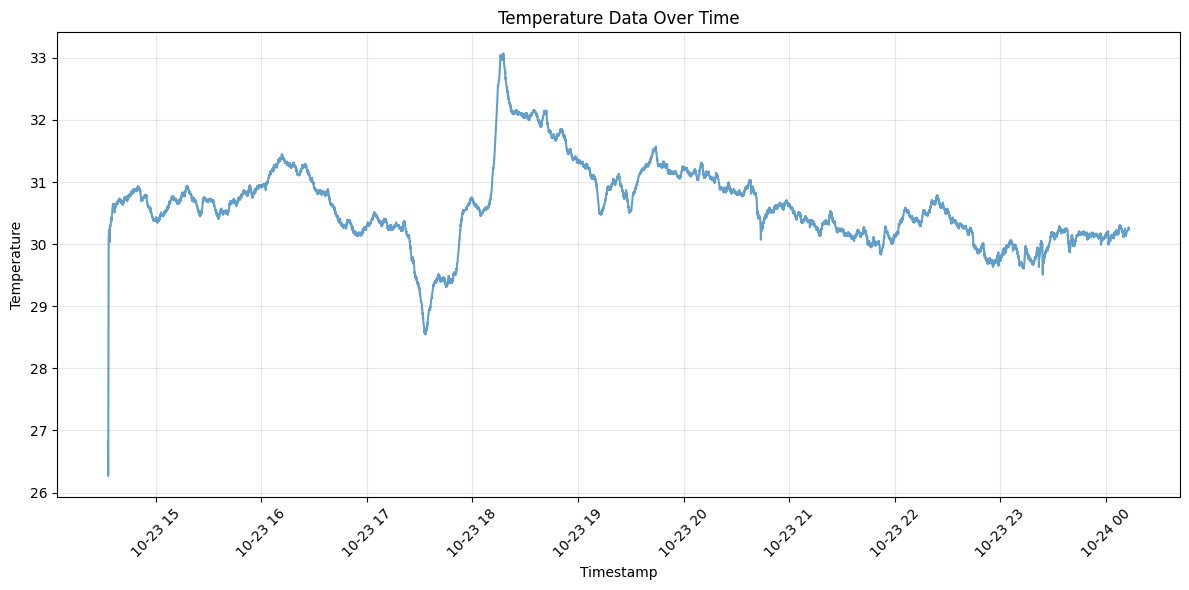

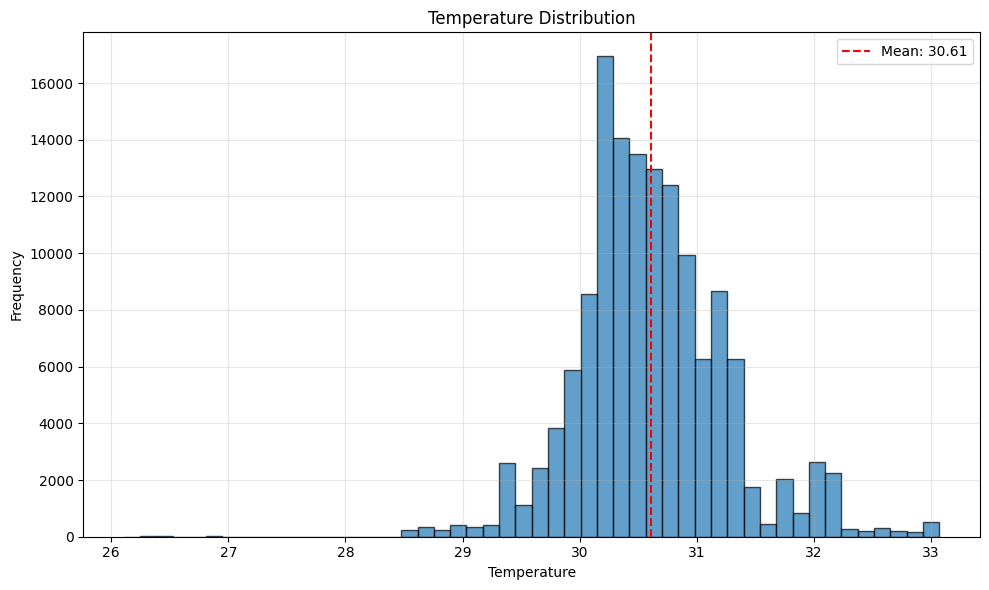

In [7]:
df = debug_temperature_processing("../data/raw/EG/EG_1603463571")
plot_temperature_data(df)

In [12]:
data = pd.read_csv("../data/processed/participant_EG_features_1sessions.csv")

In [14]:
data.head()

,timestamp,temp_mean,temp_std,temp_min,temp_max,temp_range,acc_x_mean,acc_x_std,acc_x_max,acc_x_min,...,hr_mean,hr_std,hr_min,hr_max,hr_range,hr_acc_ratio,hrv_mean_ibi,hrv_rmssd,hrv_sdnn,hrv_pnn50
0,2020-10-23 14:32:50,26.523333,0.201934,26.27,26.81,0.54,-43.642361,3.198521,-41.0,-54.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-10-23 14:33:00,28.600000,1.843369,26.11,30.47,4.36,36.056250,34.984053,86.0,-46.0,...,73.666667,5.341636,64.00,79.75,15.75,1.157198,NaN,NaN,NaN,NaN
2,2020-10-23 14:33:10,30.216000,0.161035,30.07,30.51,0.44,48.662500,29.340160,114.0,-39.0,...,73.218000,1.276008,71.63,75.20,3.57,1.147986,NaN,NaN,NaN,NaN
3,2020-10-23 14:33:20,30.186000,0.036006,30.13,30.23,0.10,36.009375,22.548796,70.0,-16.0,...,72.036000,0.525255,71.43,72.97,1.54,1.150262,NaN,NaN,NaN,NaN
4,2020-10-23 14:33:30,30.250000,0.020255,30.23,30.29,0.06,47.181250,22.080040,100.0,-53.0,...,73.302000,0.196401,72.97,73.56,0.59,1.151807,NaN,NaN,NaN,NaN
